# Innoforest - DataFrame

### *Objective*: Create a dataset containing Sentinel-2 spectral and temporal profiles for various trees species

We first import the required packages

In [1]:
import pandas as pd
import rasterio 
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import glob

In [2]:
arg = 'val'

## Tree species

*Rq: no background class was included, deliberately, this can easily be changed*

Let us start with the tree species label

In [3]:
species_path = os.path.join('forest-types', 'filtered', f'foresttypes-32VNH-filtered-{arg}.tif')
with rasterio.open(species_path) as src:
    profile = src.profile
    species = src.read(1)
print(species.shape)

(10980, 10980)


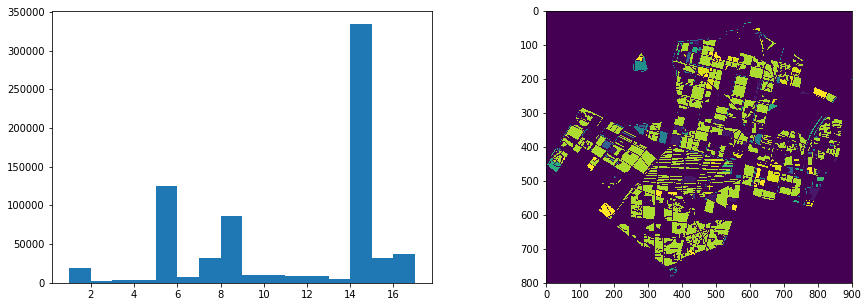

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
counts = ax[0].hist(species[species>0], bins=16, range=(1, 17))
ax[1].imshow(species[8100:8900, 1600:2500])

The dataset contains an unequal number of trees from each species, the minortity class contains 2657 pixels (for the training set), let us use all the pixels of this class but randomly select the same amount for all the other classes.

In [5]:
minority_class_count = int(np.min(counts[0]))
print(minority_class_count)

2657


In [6]:
reduced_labels = 0*species
pixel_coordinates = []
for tree_species in tqdm(range(1, 17)):
    coordinates = np.argwhere(species==tree_species) # list of coordinates where this tree species is present
    idx_selected_pixels = np.random.choice(range(len(coordinates)), minority_class_count, replace=False)
    selected_pixels = coordinates[idx_selected_pixels]
    pixel_coordinates.append(selected_pixels)
    reduced_labels[selected_pixels[:, 0], selected_pixels[:, 1]] = tree_species

100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


In [7]:
pixel_coordinates = np.array(pixel_coordinates)
pixel_coordinates.shape

(16, 2657, 2)

We should now have a balanced dataset in the **reduced_labels** raster

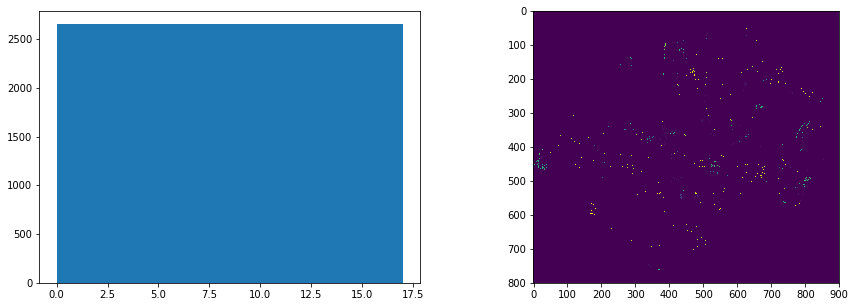

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
counts = ax[0].hist(reduced_labels[reduced_labels>0], bins=16, range=(0, 17))
ax[1].imshow(reduced_labels[8100:8900, 1600:2500])

In [9]:
species[selected_pixels[:, 0], selected_pixels[:, 1]]

array([16, 16, 16, ..., 16, 16, 16], dtype=int16)

## Initialize a DataFrame

Create a DataFrame containing features for 2500 pixels representing each class

In [10]:
df = pd.DataFrame()

Add coordinates on the raster and corresponding labels (target variable y)

In [11]:
df['coord_x_32VNH'] = pixel_coordinates[:, :, 0].flatten()
df['coord_y_32VNH'] = pixel_coordinates[:, :, 1].flatten()
df['y'] = 1 + np.arange(16*minority_class_count)//minority_class_count

Add corresponding labels (target variable y)

In [12]:
df['y'] = 1 + np.arange(16*minority_class_count)//minority_class_count

In [13]:
df.head()

,coord_x_32VNH,coord_y_32VNH,y
0,8441,1999,1
1,349,5186,1
2,4682,495,1
3,9083,1347,1
4,5948,1736,1


## Add the optical data

List of the optical bands, we have 10 months of interpolated imagery with 5-days interval for each of these

In [14]:
bands = os.listdir('32VNH')[:-1]
print(bands)

['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B11', 'B12', 'B8A', 'ccmi', 'ndmi', 'ndti', 'ndvi', 're75', 're8A6']


In [15]:
# pixels to extract
x, y = pixel_coordinates[:, :, 0].flatten(), pixel_coordinates[:, :, 1].flatten()

In [16]:
for band in bands:
    
    raster_paths = glob.glob(os.path.join('32VNH', band, 'S2*.tif'))
    
    for raster_path in tqdm(raster_paths):
        
        day_of_year = pd.to_datetime(os.path.split(raster_path)[-1].split('_')[2]).strftime('%j')
        
        with rasterio.open(raster_path) as src:
            df[f'{band}_{day_of_year}'] = src.read(1)[x,y]

100%|██████████| 60/60 [04:55<00:00,  4.95s/it]


This step can be quite slow, I tried to open only the necessary pixels instead of the whole raster but it is actually 20% slower. It is probably worth it when only 100-1000 pixels need to be sampled

In [18]:
df.to_csv(f'tree_species_{arg}.csv')

Plot NDVI profiles of the different trees species

In [33]:
ndvi_cols = [col for col in df.columns if 'ndvi' in col]
ndvi = np.array(df.groupby('y').mean()[ndvi_cols])

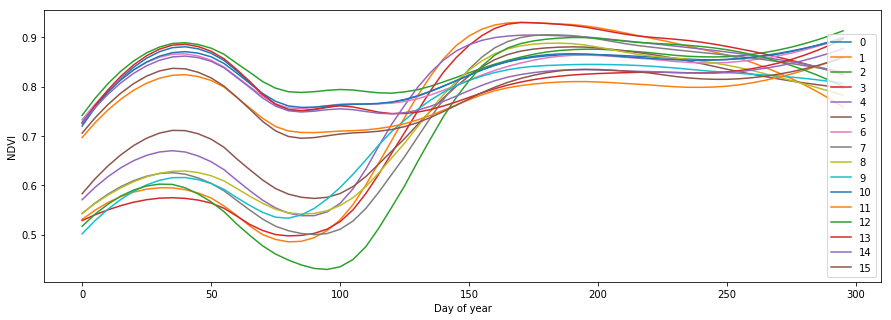

In [39]:
plt.figure(figsize = (15, 5))
for tree_species in range(16):
    plt.plot(5*np.arange(ndvi.shape[1]), ndvi[tree_species, :]/10000, label = str(tree_species))
plt.xlabel('Day of year')
plt.ylabel('NDVI')
plt.legend()

In [ ]:
ndvi_cols = [col for col in df.columns if 'ndmi' in col]
ndvi = np.array(df.groupby('y').mean()[ndvi_cols])

Open dataset

In [ ]:
df = "/nas02/kegro/dk-sentinel-2/2022/interpolated/32VNH/B08/S2_32VNH_20220105_B08.tif"